# [OPTIONAL] Set up Colab to run locally

If you want to run this Colab on your local files, follow the instructions here!

1. Create a Python virtual environment, a local directory that contains all of the dependencies your code needs to run:

        python -m venv env
        source env/bin/activate

2. Install Jupyter and enable the Colab extension (see https://research.google.com/colaboratory/local-runtimes.html):

        pip install jupyter
        pip install jupyter_http_over_ws
        jupyter serverextension enable --py jupyter_http_over_ws
        jupyter notebook \
            --NotebookApp.allow_origin='https://colab.research.google.com' \
            --port=8888 \
            --NotebookApp.port_retries=0

3. In the output of this command, there will be a link that looks like:

        http://localhost:8888/?token=abc12345

  4. Click the the arrow next to "Connect" in the upper right of this screen.
  5. Select "Connect to a local runtime"
  6. Paste the link from the output of the command above.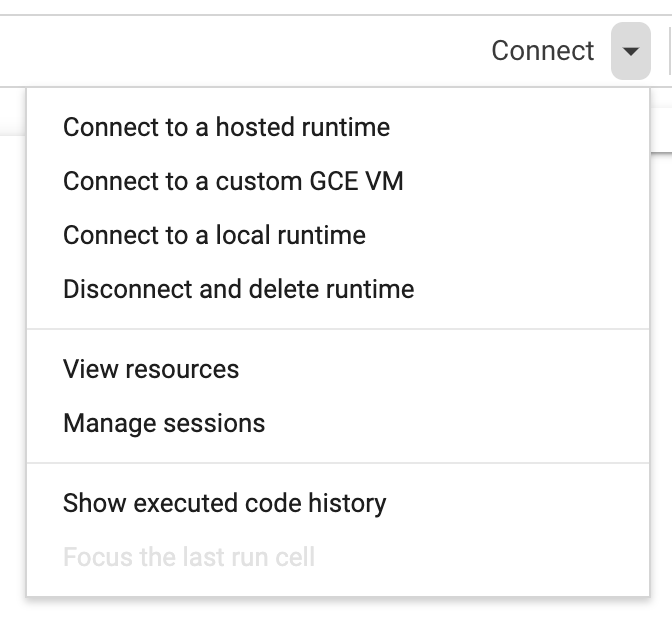

# Installation

Install the CXR Foundation Python Library

In [1]:
!pip install cxr-foundation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 6.2 MB/s 
     |████████████████████████████████| 2.0 MB 17.0 MB/s 
     |████████████████████████████████| 58 kB 3.0 MB/s 
     |████████████████████████████████| 11.0 MB 33.8 MB/s 
     |████████████████████████████████| 578.0 MB 16 kB/s 
     |████████████████████████████████| 2.2 MB 40.9 MB/s 
     |████████████████████████████████| 2.3 MB 37.4 MB/s 
     |████████████████████████████████| 438 kB 42.1 MB/s 
     |████████████████████████████████| 1.7 MB 36.0 MB/s 
     |████████████████████████████████| 5.9 MB 34.1 MB/s 
     |████████████████████████████████| 38.2 MB 1.4 MB/s 
     |████████████████████████████████| 5.9 MB 46.2 MB/s 
     |████████████████████████████████| 1.1 MB 44.5 MB/s 
     |████████████████████████████████| 116 kB 48.1 MB/s 
     |████████████████████████████████| 238 kB 48.1 MB/s 
     |███████████████████████████

*Did you restart the runtime?*

If you are using Google Colab, the runtime must be restarted after installing new packages.

NOTE: You will have some ERROR messages due to the protobuf library - this is normal.

Create a directory for your data.

In [1]:
!mkdir data

Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.

In [2]:
from google.cloud import storage

import io
import os
import pandas as pd
import sys

if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

You can find sample DICOMs from the sample DICOMs from Chest X-ray14 dataset on [Cloud](https://cloud.google.com/healthcare-api/docs/resources/public-datasets/nih-chest). We will download some below. This might take ~10 minutes or so depending on your connection speed.

In [3]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('cxr-foundation-demo')
head = 'AIRSPACE_OPACITY'
labels_df = pd.read_csv(io.BytesIO(bucket.blob('cxr14/labels.csv').download_as_string()))
labels_df['filename'] = labels_df['image_id'].apply(lambda x: os.path.join('cxr14', 'inputs', x.split('.')[0] + '.dcm'))
labels = [(1, 'positive'), (0, 'negative')]
for label, label_name in labels:
  dir = os.path.join('./data', 'inputs', f'{head}_{label_name}')
  if not os.path.exists(dir):
    os.makedirs(dir)
  for i, fname in enumerate(labels_df[labels_df[head] == label]['filename'].values):
    if i > 100:
      break
    blob = bucket.blob(fname)
    if blob.exists():
      blob.download_to_filename(os.path.join(dir, os.path.basename(blob.name)))

# Generate Embeddings

In [4]:
import glob
import os
import pandas as pd
import sys
import tensorflow as tf

from sklearn.model_selection import train_test_split

from google.cloud import storage

if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

Create an output directory for the generated embeddings.

In [5]:
!mkdir ./data/outputs

Generate embeddings (think of them as compressed images) from all your local input DICOMs. You can also run this command from your command line (without the `!`). This may take ~15 minutes depending on the load on the server and your connection speed. There may be some warnings about "Could not load dynamic library" and or "No project ID could be determined," but these can be safely ignored.

In [6]:
!python -m cxr_foundation.run_inference \
  --input_path "./data/inputs/*/*.dcm" \
  --output_path "./data/outputs" \
  --input_file_type='dicom' \
  --limit -1  # setting this flag to -1 means unlimited

2022-11-07 20:42:43.197925: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 20:42:44.215255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-07 20:42:44.215429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-07 20:42:44.215470: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make su

Examine one of the output files:

In [7]:
raw_dataset = tf.data.TFRecordDataset(glob.glob('./data/outputs/*.tfrecord'))
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "embedding"
    value {
      float_list {
        value: -0.23271647095680237
        value: -1.209999442100525
        value: 1.5938202142715454
        value: -1.2897697687149048
        value: -0.0638207420706749
        value: 0.09241782873868942
        value: 0.61900794506073
        value: 0.43086060881614685
        value: 0.5445286631584167
        value: 0.5885334014892578
        value: 0.5423259139060974
        value: 0.4948732852935791
        value: -1.2236772775650024
        value: 0.9695137739181519
        value: 2.862513780593872
        value: 1.0919021368026733
        value: -0.8822982311248779
        value: 1.1497561931610107
        value: 0.6126875877380371
        value: 0.8643406629562378
        value: 0.5785022974014282
        value: 0.7537901997566223
        value: -0.11689309775829315
        value: 0.59991854429245
        value: -0.8338075280189514
        value: -0.0420084111392498
        value: -0.85906583070755
 

Note that the `image/id` feature within the `tf.Example` is set to the input filename. This will become the identifier for this image when we create our labels CSV.

In [8]:
example.features.feature['image/id'].bytes_list.value[0]

b'./data/inputs/AIRSPACE_OPACITY_negative/00027108_012.dcm'

# Create a labels file

Now let's create a labels CSV file using the directory structure of our input files. All of the DICOM images in the `AIRSPACE_OPACITY_negative` folder will have a label of 0 and all of the DICOM images in the `AIRSPACE_OPACITY_positive` folder will have a label of 1.

In [9]:
labels_df = pd.DataFrame(glob.glob('./data/inputs/*/*.dcm'), columns=['image_id'])

In [10]:
labels_df.head()

,image_id
0,./data/inputs/AIRSPACE_OPACITY_positive/000151...
1,./data/inputs/AIRSPACE_OPACITY_positive/000120...
2,./data/inputs/AIRSPACE_OPACITY_positive/000138...
3,./data/inputs/AIRSPACE_OPACITY_positive/000202...
4,./data/inputs/AIRSPACE_OPACITY_positive/000079...


We add a column for `AIRSPACE_OPACITY` based on which folder the input file was in.

In [11]:
labels_df['AIRSPACE_OPACITY'] = labels_df['image_id'].apply(lambda x: int('positive' in x))

In [12]:
labels_df.head()

,image_id,AIRSPACE_OPACITY
0,./data/inputs/AIRSPACE_OPACITY_positive/000151...,1
1,./data/inputs/AIRSPACE_OPACITY_positive/000120...,1
2,./data/inputs/AIRSPACE_OPACITY_positive/000138...,1
3,./data/inputs/AIRSPACE_OPACITY_positive/000202...,1
4,./data/inputs/AIRSPACE_OPACITY_positive/000079...,1


If we don't have a dedicated train/tune split, we can just hold out 10% of our data to create a tune set.

In [13]:
train, tune = train_test_split(labels_df, test_size=0.1)
train['split'] = 'train'
tune['split'] = 'tune'
labels_df = pd.concat([train, tune])

In [14]:
labels_df.head()

,image_id,AIRSPACE_OPACITY,split
73,./data/inputs/AIRSPACE_OPACITY_positive/000186...,1,train
178,./data/inputs/AIRSPACE_OPACITY_negative/000004...,0,train
37,./data/inputs/AIRSPACE_OPACITY_positive/000185...,1,train
7,./data/inputs/AIRSPACE_OPACITY_positive/000214...,1,train
18,./data/inputs/AIRSPACE_OPACITY_positive/000028...,1,train


We save our DataFrame as a CSV file:

In [15]:
labels_df.to_csv('./data/labels.csv')

# Train our model

Finally, we can train our model! It should take < 5 minutes to train 100 epochs!

In [16]:
!python -m cxr_foundation.train \
  --train_split_name train \
  --tune_split_name tune \
  --labels_csv ./data/labels.csv \
  --head_name AIRSPACE_OPACITY \
  --data_dir ./data/outputs/ \
  --num_epochs 100

2022-11-07 21:00:58.037624: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 21:00:59.458105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-07 21:00:59.458318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-07 21:00:59.458347: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make su

In [17]:
model = tf.keras.models.load_model('./data/outputs/model')

/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:328: UserWarning: cxr_foundation.train_lib is not loaded, but a Lambda layer uses it. It may cause errors.
  config, custom_objects, "function", "module", "function_type"


In [18]:
model.compile()

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1376)]            0         
                                                                 
 dense (Dense)               (None, 512)               705024    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                             